In [1]:
# load packages
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf, ccf
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sys
from datetime import datetime
import numpy as np
from Swing import Swing
from Swing.util.Evaluator import Evaluator
import numpy as np

import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

sys.path.append("../pipelines")
import Pipelines as tdw

def get_experiment_list(filename):
    # load files
    timecourse = pd.read_csv(filename, sep="\t")
    # divide into list of dataframes
    experiments = []
    for i in range(0,85,21):
        experiments.append(timecourse.ix[i:i+20])
    #reformat
    for idx,exp in enumerate(experiments):
        exp = exp.set_index('Time')
        experiments[idx]=exp
    return(experiments)

In [2]:
data_folder = "/projects/p20519/roller_output/optimizing_window_size/RandomForest/insilico_size10_1/"

output_path = "/home/jjw036/Roller/insilico_size10_1"

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
save_path = ('./window_size_selection_swing_results.pickle')

data_folder = "../output/insilico_size10_1"
file_path = "../data/dream4/insilico_size10_1_timeseries.tsv"
run_params = {'data_folder': data_folder,
              'file_path':file_path,
              'td_window':10,
              'min_lag':1,
              'max_lag':3,
              'n_trees':10,
              'permutation_n':10,
              'lag_method':'mean_mean',
              'calc_mse':False,
              'bootstrap_n':100,
              'n_trials':1,
              'run_time':current_time,
              'sort_by':'adj',
              'iterating_param':'td_window',
              }

try:
    tdr = pd.read_pickle(save_path)
except:
    roc,pr, tdr = tdw.get_td_stats(**run_params)
    pd.to_pickle(tdr, save_path)

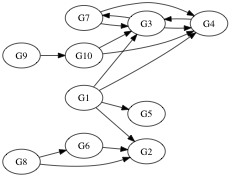

In [10]:
#list of nodes = G1..G10
nodes = ['G'+str(x) for x in range(1,11)]
#convert edge list to list of tuples
edges = pd.read_csv("../data/dream4/insilico_size10_1_goldstandard.tsv",sep="\t",header=None)
edges = edges[edges[2] > 0]
edges=edges[edges.columns[0:2]]
edges = [tuple(x) for x in edges.values]
G = nx.DiGraph()
G.graph['rankdir'] = 'LR'
G.graph['dpi'] = 50


G.add_nodes_from(nodes)
G.add_edges_from(edges)
#examples of other kinds of drawing
#G.add_node(0, color='red', style='filled', fillcolor='pink')
#G.add_node(1, shape='square')
#G.add_node(3, style='filled', fillcolor='#00ffff')
#G.add_edge(0, 1, color='red', style='dashed')
#G.add_edge(3, 3, label='a')
draw(G)

In [3]:
experiments=get_experiment_list(file_path)

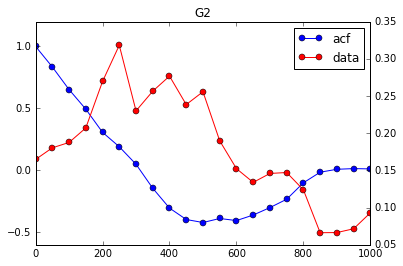

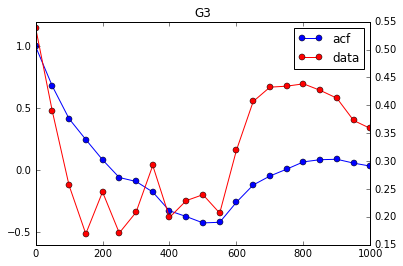

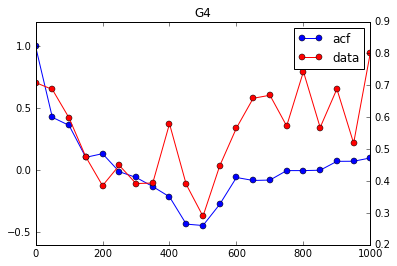

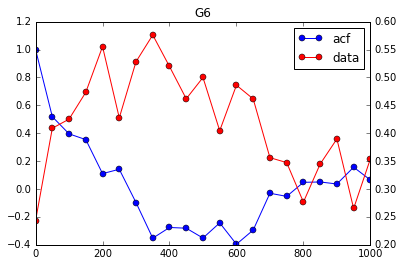

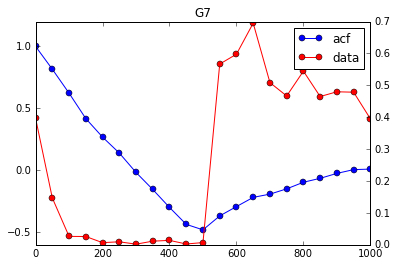

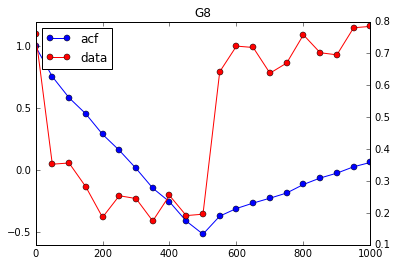

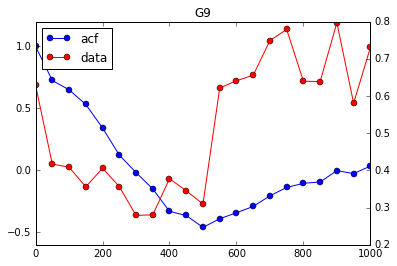

In [4]:
ce = 3
for gene in tdr.gene_list:
    auto = acf(experiments[ce][gene])
    x = stats.linregress(tdr.time_vec[:10], auto[:10])
    p_val = x[3]*len(tdr.gene_list)
    if p_val < 0.05:
        fig, ax1 = plt.subplots()
        ln1= ax1.plot(tdr.time_vec, auto, 'o-', label='acf')
        ax2 = ax1.twinx()
        ln2 = ax2.plot(tdr.time_vec, (experiments[ce][gene]), 'o-', c='r', label='data')
        lns = ln1+ln2
        labs = [l.get_label() for l in lns]
        ax2.legend(lns, labs, loc='best')
        plt.title(gene)

# This may represent the genes that should be used as child nodes in the regression for THIS experiment

In [5]:
current_gold_standard = file_path.replace("timeseries.tsv","goldstandard.tsv")
evaluator = Evaluator(current_gold_standard, '\t')
true_edges = evaluator.gs_flat.tolist()
print(true_edges)

[('G1', 'G2'), ('G1', 'G3'), ('G1', 'G4'), ('G1', 'G5'), ('G3', 'G4'), ('G3', 'G7'), ('G4', 'G3'), ('G6', 'G2'), ('G7', 'G3'), ('G7', 'G4'), ('G8', 'G2'), ('G8', 'G6'), ('G9', 'G10'), ('G10', 'G3'), ('G10', 'G4')]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
  Parent Child        Slope     Pval
0     G1    G1 -0.000962218  28.1454
1     G1    G2   0.00067111  2.10543
2     G1    G3 -0.000383584  45.2553
3     G1    G4 -0.000368982  50.5957
4     G1    G5 -0.000398608  54.2954


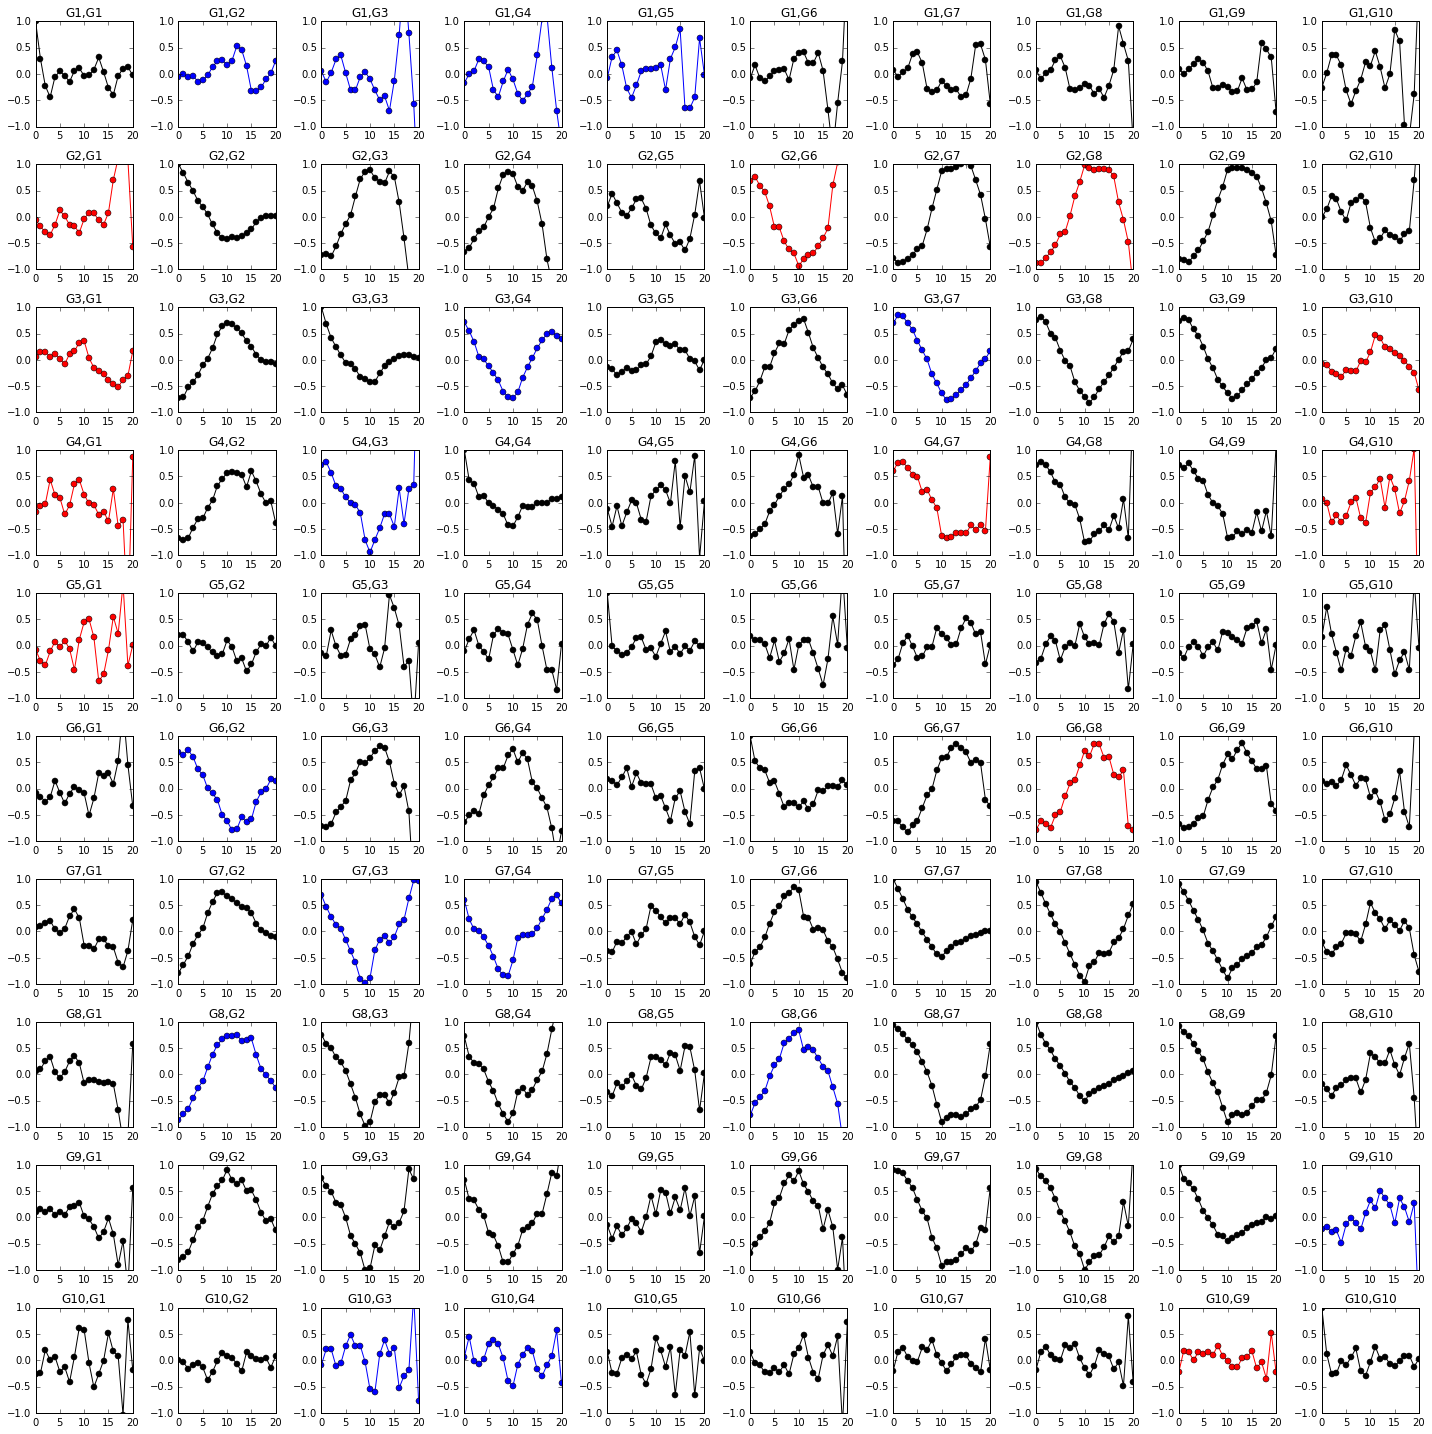

In [6]:
f = plt.figure(figsize=(20,20))
ii = 1
parent = []
child = []
slope = []
p_value = []
for gene1 in tdr.gene_list:
    for gene2 in tdr.gene_list:
        current_ax = f.add_subplot(len(tdr.gene_list),len(tdr.gene_list) , ii)
        if ((gene1, gene2) in true_edges):
            color = 'b'
        elif (((gene2, gene1) in true_edges)):
            color = 'r'
        else:
            color = 'k'
        unbiased = True
        if (gene1 == gene2):
            # Not clear why this is the case by statsmodels uses unbiased=False for acf
            # unbiased = False for ccf yields the same results as acf
            unbiased = False
        parent.append(gene1)
        child.append(gene2)
        ccf_results = ccf(experiments[ce][gene1], experiments[ce][gene2], unbiased=unbiased)
        x = stats.linregress(tdr.time_vec[:10], ccf_results[:10])
        slope.append(x.slope)
        p_value.append(x.pvalue*(len(tdr.gene_list)**2))
        current_ax.plot(ccf_results, 'o-', c=color)
        current_ax.set_title(gene1+','+gene2)
        current_ax.set_ylim([-1, 1])
        print(ii)
        ii+=1
plt.tight_layout()
df = pd.DataFrame([parent, child, slope, p_value], index=['Parent', 'Child', 'Slope', 'Pval']).T
print(df.head())

In [7]:
# This might be the list of edges that should even be considered
df[(df['Pval']<0.05) &(df['Parent']!=df['Child'])]
df['Abs_slope'] = np.abs(df['Slope'])
df.sort(columns='Abs_slope', inplace=True, ascending=False)
df

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Parent,Child,Slope,Pval,Abs_slope
67,G7,G8,-0.00389682,1.8671e-11,0.00389682
12,G2,G3,0.00389642,0.00035715,0.00389642
82,G9,G3,-0.0038559,6.20894e-06,0.0038559
72,G8,G3,-0.00381325,3.02002e-05,0.00381325
87,G9,G8,-0.00374579,9.78045e-07,0.00374579
62,G7,G3,-0.00372203,5.01792e-07,0.00372203
81,G9,G2,0.0037185,1.12939e-06,0.0037185
68,G7,G9,-0.00370685,5.88639e-10,0.00370685
61,G7,G2,0.00368295,3.85566e-07,0.00368295
71,G8,G2,0.00364035,3.13616e-07,0.00364035


### Are cross-correlation and moving pearson the same?
If formulated properly, they appear to be the same. See test example below.

In [8]:
a = np.array([1,3,2,6])
ai = a-a.mean()
(np.correlate(ai,ai, 'full')[len(a)-1:]/np.array([4,3,2,1]))/np.std(a)**2

array([ 1.        , -0.28571429,  0.28571429, -1.71428571])

In [9]:
ccf(a,a)

array([ 1.        , -0.28571429,  0.28571429, -1.71428571])

In [10]:
stats.pearsonr([1,3,2,6], [1,3,2,6])

(1.0, 0.0)

In [11]:
stats.pearsonr([3,2,6], [1,3,2])

(-0.24019223070763066, 0.84557904168873266)

In [12]:
stats.pearsonr([2,6], [1,3])

(1.0, 0.0)

In [13]:
a_trunc = np.array([3,2,6])
a_shift = np.array([1,3,2])
ccov = np.mean((a_trunc-a.mean())*(a_shift-a.mean()))/(np.std(a)**2)
ccov

-0.2857142857142857

In [14]:
a_trunc = np.array([2,6])
a_shift = np.array([1,3])
ccov = np.mean((a_trunc-a.mean())*(a_shift-a.mean()))/(np.std(a)**2)
ccov

0.2857142857142857

### Let's try on real data

In [15]:
# How does pearson correlation compare to cross correlation
g1 = 'G1'
g2 = 'G2'
######################################################################################################################
#NOTE: If you don't take the values from the pd dataframe it messes things up
######################################################################################################################
g1_data = experiments[1][g1].values
g2_data = experiments[1][g2].values
ccf_results = ccf(g1_data, g2_data)

In [16]:
vals = []
for ii in range(len(g1_data)-1):
    trunc_g1 = g1_data[ii:,]
    if ii == 0:
        shift_g2 = g2_data[:]
    else:
        shift_g2 = g2_data[:-ii,]
    ccov = np.mean((trunc_g1-g1_data.mean())*(shift_g2-g2_data.mean()))
    vals.append(ccov/(np.std(g1_data)*np.std(g2_data)))

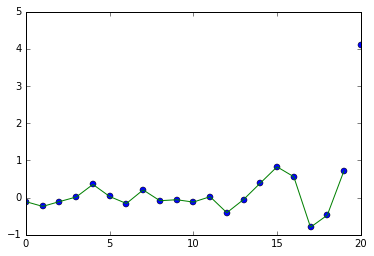

In [17]:
plt.figure()
plt.plot(ccf_results, 'o')
plt.plot(vals)

### Now let's look at some real lags and see what is going on

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


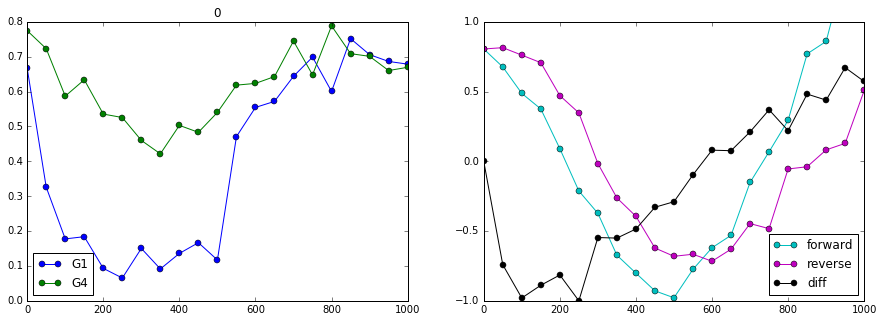

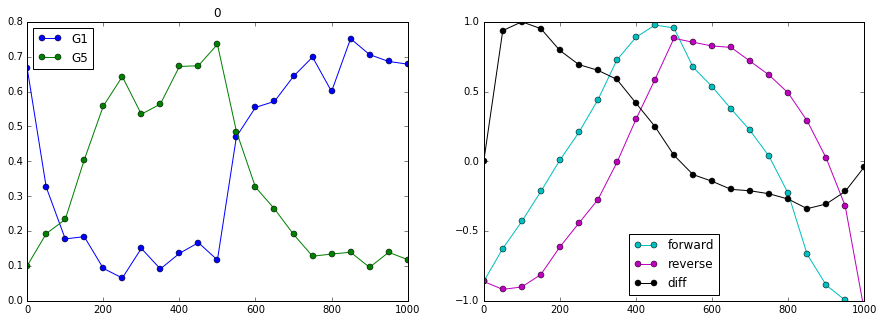

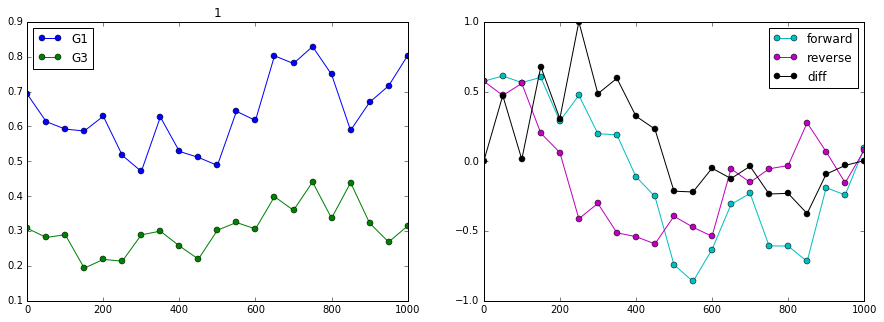

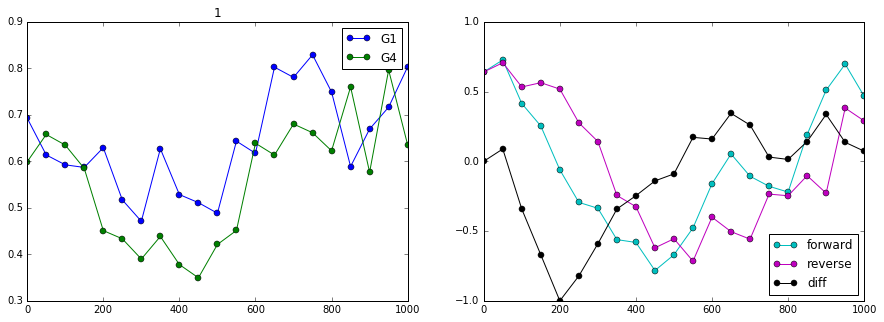

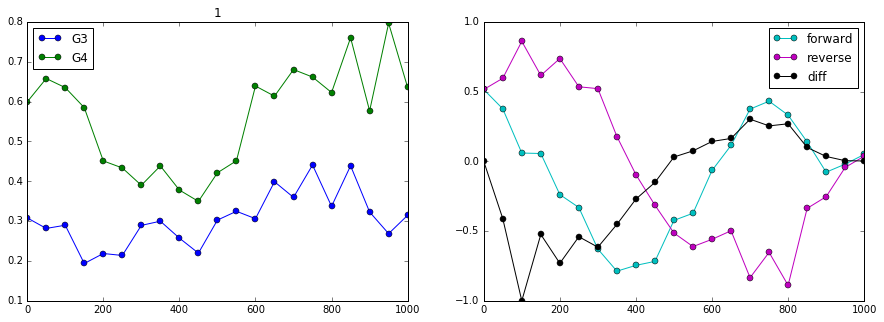

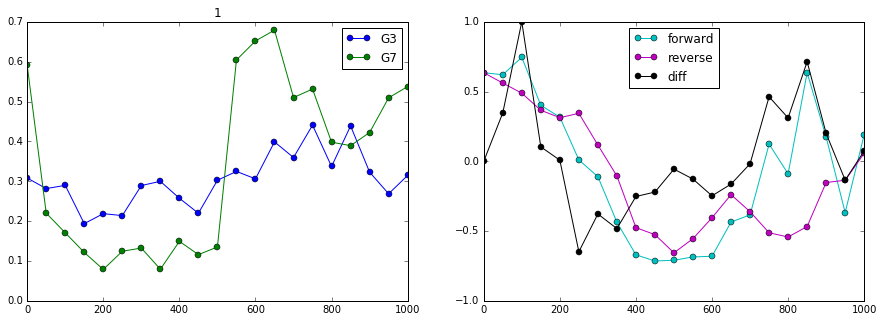

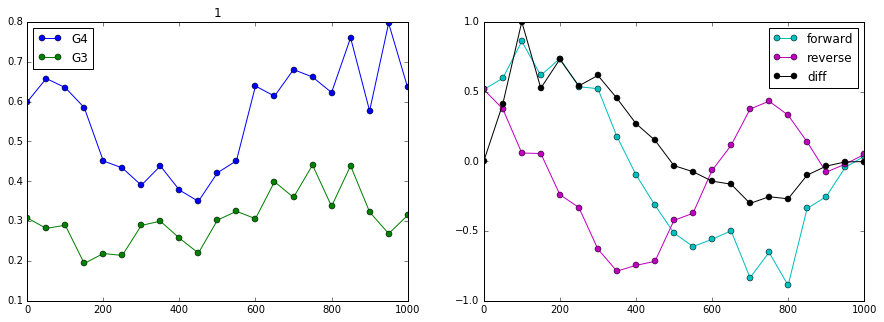

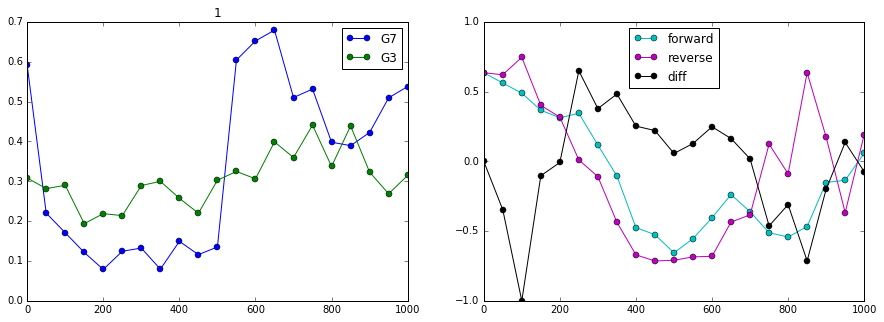

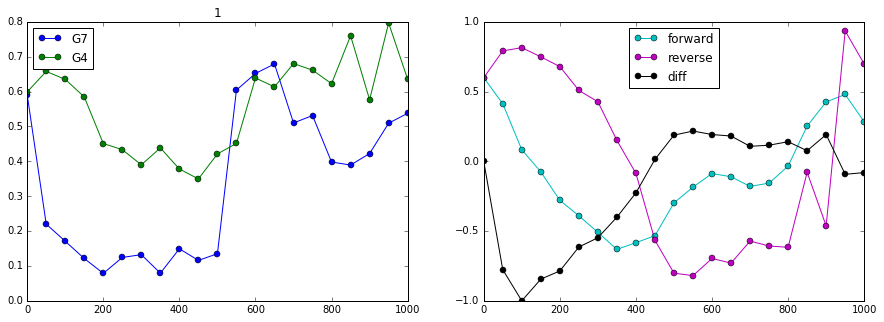

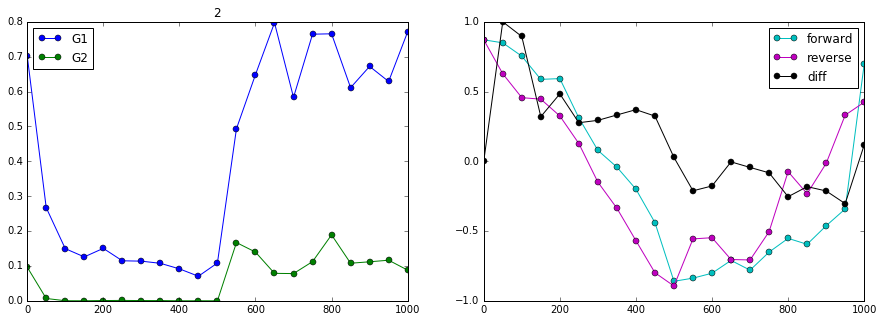

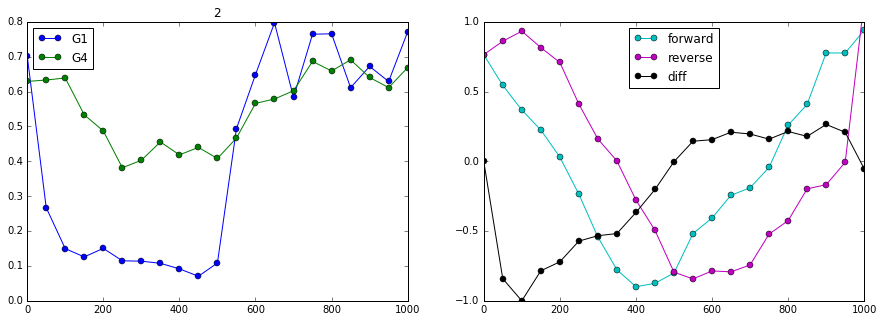

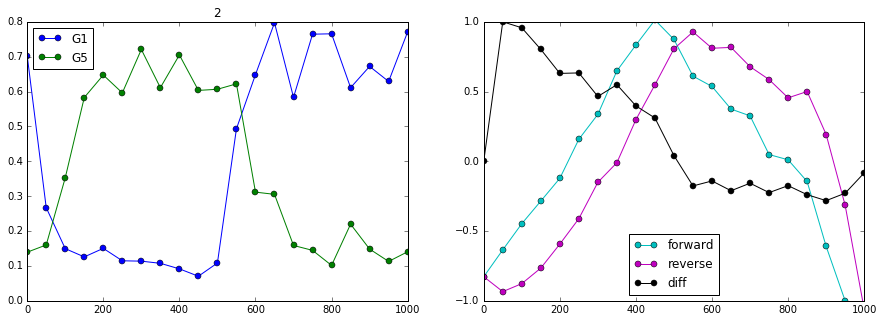

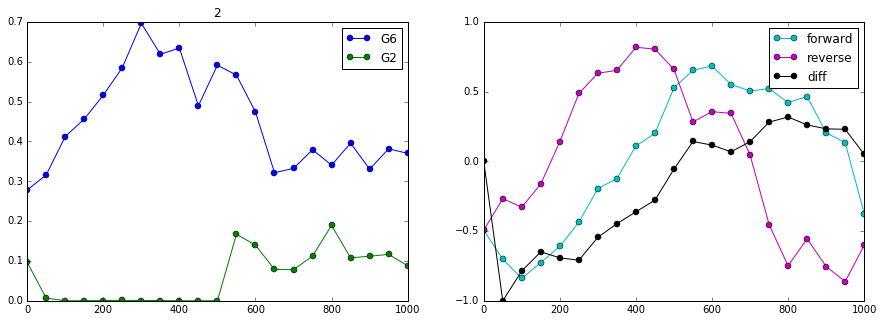

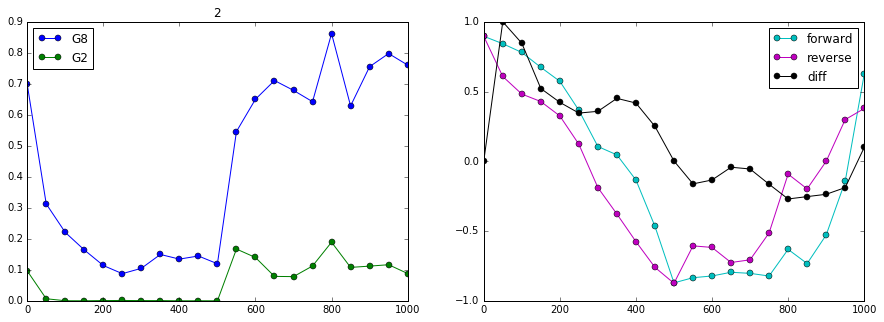

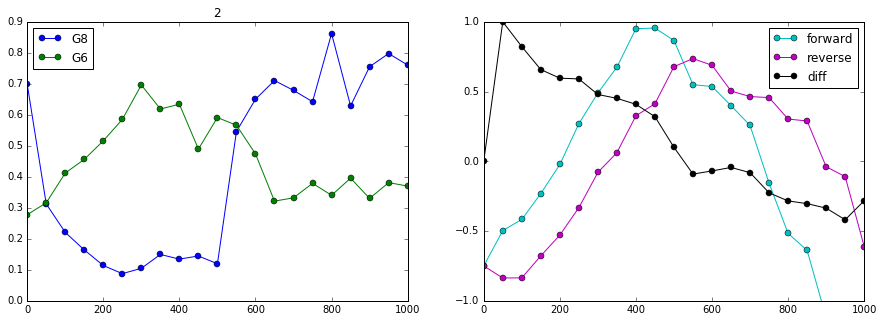

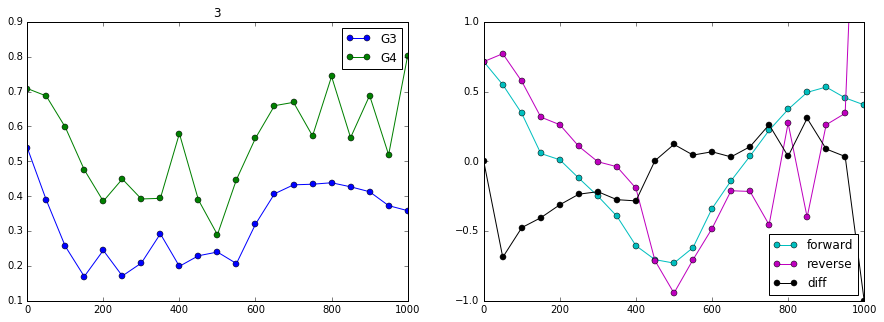

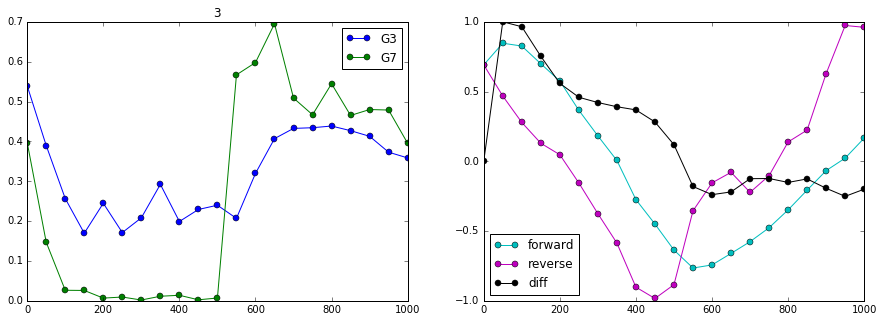

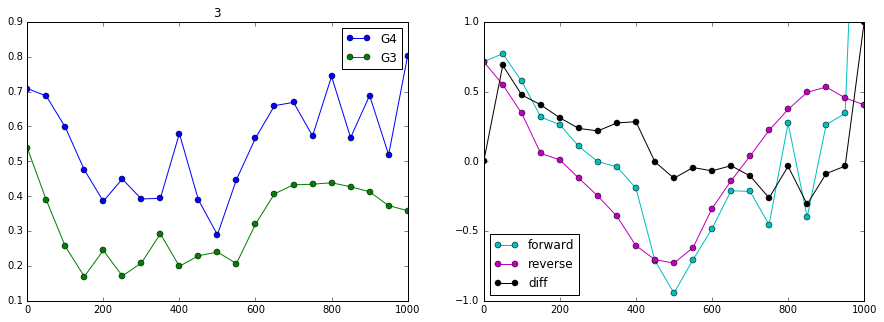

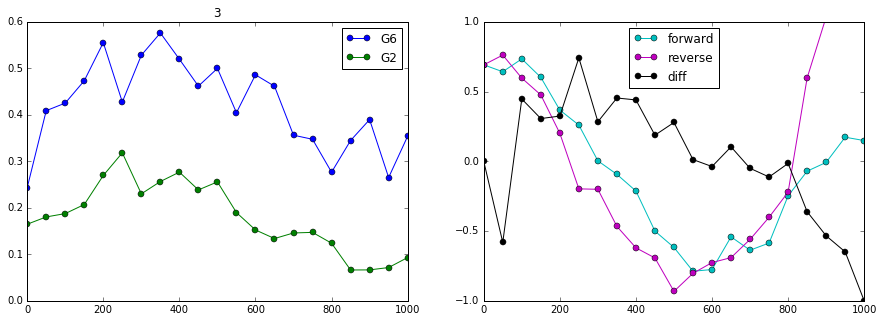

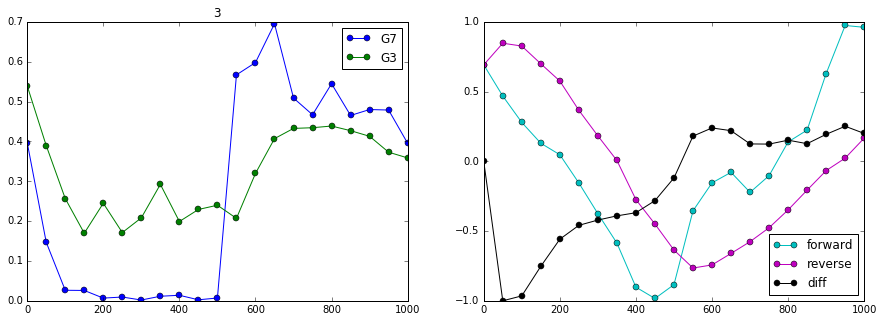

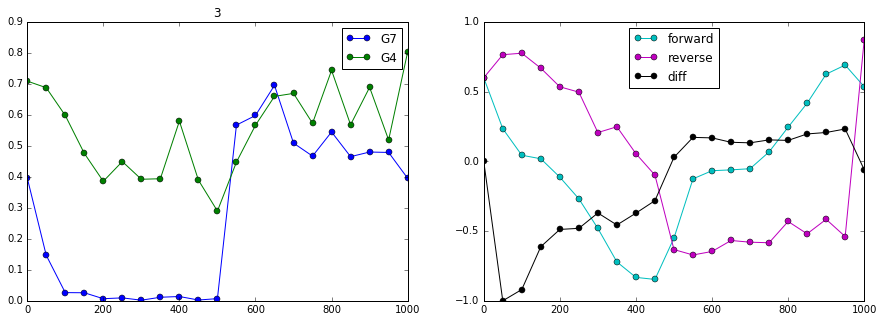

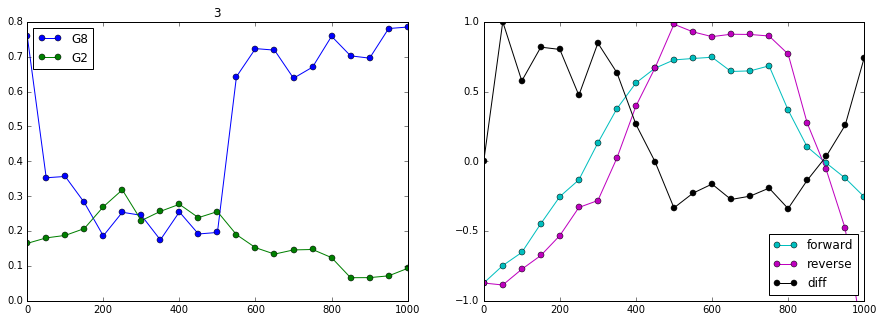

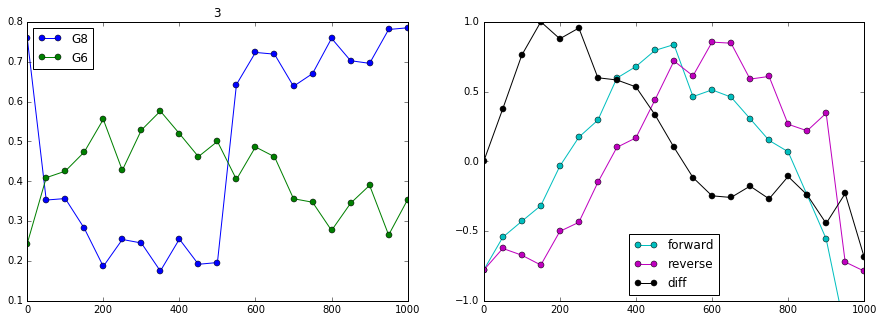

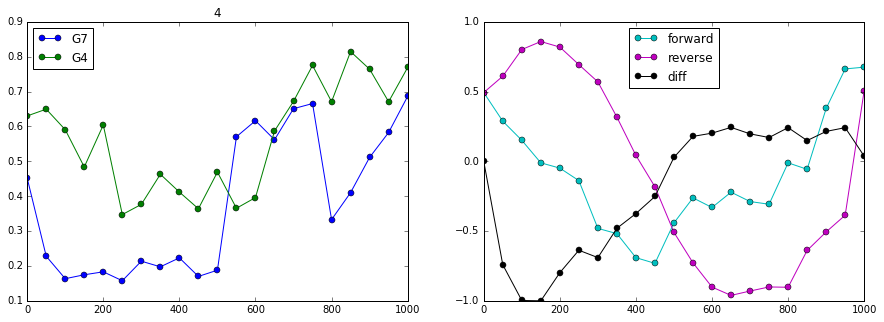

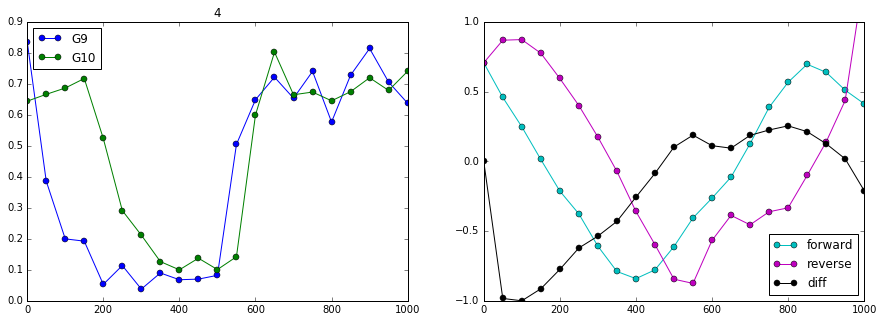

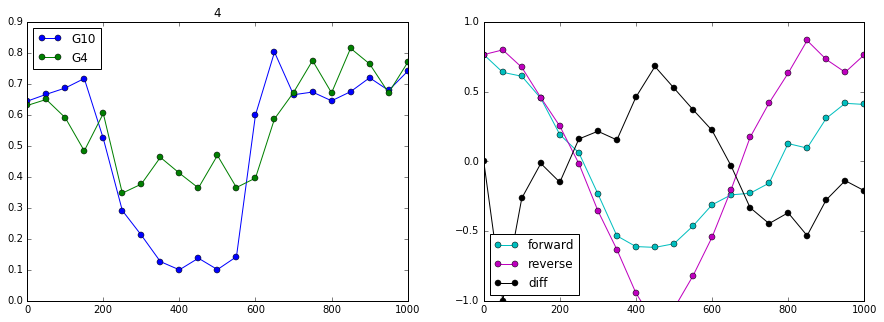

In [167]:
np.set_printoptions(linewidth=500)
def identify_lags(experiments, true_edges, swing_obj, perturb_idx=0, auto_len=10, p_thresh=0.05):
    for ee, experiment in enumerate(experiments):
        for parent, child in true_edges:
            data_df = pd.DataFrame()
            data_df['Parent'] = experiment[parent]
            data_df['Child'] = experiment[child]
            auto_parent = acf(data_df['Parent'])
            auto_child = acf(data_df['Child'])
            pval_parent = stats.linregress(data_df.index[:auto_len], auto_parent[:auto_len]).pvalue*len(swing_obj.gene_list)
            pval_child = stats.linregress(data_df.index[:auto_len], auto_child[:auto_len]).pvalue*len(swing_obj.gene_list)
            if pval_parent < p_thresh and pval_child < p_thresh:
                perturb_df = data_df.iloc[perturb_idx:]
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
                ax1.plot(perturb_df.index,  perturb_df['Parent'], 'o-', label=parent)
                ax1.plot(perturb_df.index,  perturb_df['Child'], 'o-', label=child)
                ax1.set_title(ee)
                ax1.legend(loc='best')
                ccf_forward = ccf(perturb_df['Parent'],  perturb_df['Child'])
                ccf_reverse = ccf( perturb_df['Child'], perturb_df['Parent'])
                diff = (ccf_forward-ccf_reverse)/range(1,len(perturb_df.index)+1)
                diff = diff/np.max(np.abs(diff))
                ax2.plot(perturb_df.index, ccf_forward, 'o-', c='c', label='forward')
                ax2.plot(perturb_df.index, ccf_reverse, 'o-', c='m', label='reverse')
                ax2.plot(perturb_df.index, diff, 'o-', c='k', label='diff')
                ax2.set_ylim([-1, 1])
                ax2.legend(loc='best')

identify_lags(experiments, true_edges, tdr)

500.0